In [53]:
import struct
import numpy as np
import tensorflow as tf
import skimage
from PIL import Image
from skimage.transform import resize
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imshow

画像データを訓練評価できる形にする。

ETL8Gデータベースの仕様は一つのタプルの2番目にJISコード、最後に1pixelごとのグレーレベルが入っている。

グレーレベルの最大値が1となるように規格化をし、画像の画素数を32×32にする。

In [54]:
def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [81]:
if __name__ == '__main__':
    data = []
    jis = []
    for i in range(1, 33):
        with open('../ETL8G/ETL8G_{:02d}'.format(i), 'rb') as f:
            for j in range(5*956):
                r = read_record_ETL8G(f)
                if 0x2421 <= r[1] <= 0x2473:
                    data.append((
                        resize(
                            np.asarray(r[-1])/9*255,
                            (32, 32),
                            mode='constant')/255).flatten())
                    jis.append(r[1])

学習させる画像がどんなものか見てみる。

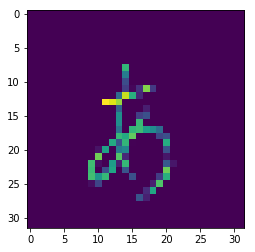

In [82]:
%matplotlib inline
def img_show(img):
    imshow(img)

img_show(data[0].reshape(32, 32))

このままではラベルがJISコード(92◯◯)のままで美しくない上にエラー吐かれるので、ラベリングをする。  
新たなラベルclassとJISコード、それを表すひらがなを内包したclassmapping.csvを用意し、それぞれのJISコードに対応するclassを取得する。

In [83]:
jis = pd.DataFrame({'jis': jis})
classmapping = pd.read_csv('../classmapping.csv', dtype={'class': np.int32}, encoding='cp932')
labels = pd.merge(
            jis,
            classmapping,
            how='left',
            on='jis')['class'].values

In [92]:
# 元データの数
data.shape

(600000, 1024)

このままではデータの数が12000枚と少ないので水増しを行う。  
kerasのImageDataGeneratorを用い、回転・上下左右へシフト・拡大などを行う。

In [84]:
# generatorの設定
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.39,
    zoom_range=0.2,
    data_format='channels_first')

In [85]:
# generatorに投げられる形にする
data = np.array(data, dtype=np.float32)
reshaped_data = data.reshape((12000, 1, 32, 32))
datagen.fit(reshaped_data)
generator = datagen.flow(reshaped_data, labels, batch_size=12000)

In [87]:
for i in range(49):
    new_dataset = generator.next()
    new_data = new_dataset[0].reshape((12000, 1024))
    new_labels = new_dataset[1]
    data = np.concatenate((data, new_data))
    labels = np.append(labels, new_labels)

In [91]:
# 水増し後のデータ数
data.shape

(600000, 1024)

データ数を12000個から600000個に増やすことができた。  
このdataflameをhira.npzとして保存する。

In [93]:
np.savez_compressed(
    './hira.npz',
    data=data,
    labels=labels)